In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]
ZR_12_TR, ZR_12_TE= ZR_12[0:50], ZR_12[50:len(ZR_12)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]
ZR_N12=ZR_N[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]
ZR_N12_TR, ZR_N12_TE= ZR_N12[0:50], ZR_N12[50:len(ZR_N12)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [7]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+1
look_back=12
look_forward=1

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)
trainX_46, train_y_46 = ZR_46_TR_I.iloc[:, 0:-1], ZR_46_TR_I.iloc[:, -1]

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)
testX_46, test_y_46 = ZR_46_TE_I.iloc[:, 0:-1], ZR_46_TE_I.iloc[:, -1]


# Inputgröße 12%
# Trainingsdaten
ZR_12_TR_I=timeseries_to_supervised_R(ZR_12_TR, look_back, look_forward)
trainX_12, train_y_12 = ZR_12_TR_I.iloc[:, 0:-1], ZR_12_TR_I.iloc[:, -1]

# Testdaten 
ZR_12_TE_I=timeseries_to_supervised_R(ZR_12_TE, look_back, look_forward)
testX_12, test_y_12 = ZR_12_TE_I.iloc[:, 0:-1], ZR_12_TE_I.iloc[:, -1]

In [8]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)
trainX_100N, train_y_100N = ZR_N100_TR_I.iloc[:, 0:-1], ZR_N100_TR_I.iloc[:, -1]

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)
testX_100N, test_y_100N = ZR_N100_TE_I.iloc[:, 0:-1], ZR_N100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)
trainX_46N, train_y_46N = ZR_N46_TR_I.iloc[:, 0:-1], ZR_N46_TR_I.iloc[:, -1]

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)
testX_46N, test_y_46N = ZR_N46_TE_I.iloc[:, 0:-1], ZR_N46_TE_I.iloc[:, -1]


# Inputgröße 12%
# Trainingsdaten
ZR_N12_TR_I=timeseries_to_supervised_R(ZR_N12_TR, look_back, look_forward)
trainX_12N, train_y_12N = ZR_N12_TR_I.iloc[:, 0:-1], ZR_N12_TR_I.iloc[:, -1]

# Testdaten 
ZR_N12_TE_I=timeseries_to_supervised_R(ZR_N12_TE, look_back, look_forward)
testX_12N, test_y_12N = ZR_N12_TE_I.iloc[:, 0:-1], ZR_N12_TE_I.iloc[:, -1]

In [27]:
# Replizierbarkeit gewährleisten
np.random.seed(3)

In [28]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(5, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))

Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 1s - loss: 0.0621 - val_loss: 0.0548
Epoch 2/200
 - 0s - loss: 0.0370 - val_loss: 0.0812
Epoch 3/200
 - 0s - loss: 0.0333 - val_loss: 0.0806
Epoch 4/200
 - 0s - loss: 0.0314 - val_loss: 0.0735
Epoch 5/200
 - 0s - loss: 0.0294 - val_loss: 0.0643
Epoch 6/200
 - 0s - loss: 0.0274 - val_loss: 0.0620
Epoch 7/200
 - 0s - loss: 0.0254 - val_loss: 0.0540
Epoch 8/200
 - 0s - loss: 0.0235 - val_loss: 0.0498
Epoch 9/200
 - 0s - loss: 0.0217 - val_loss: 0.0454
Epoch 10/200
 - 0s - loss: 0.0200 - val_loss: 0.0396
Epoch 11/200
 - 0s - loss: 0.0183 - val_loss: 0.0348
Epoch 12/200
 - 0s - loss: 0.0168 - val_loss: 0.0308
Epoch 13/200
 - 0s - loss: 0.0153 - val_loss: 0.0281
Epoch 14/200
 - 0s - loss: 0.0140 - val_loss: 0.0241
Epoch 15/200
 - 0s - loss: 0.0128 - val_loss: 0.0207
Epoch 16/200
 - 0s - loss: 0.0117 - val_loss: 0.0185
Epoch 17/200
 - 0s - loss: 0.0107 - val_loss: 0.0161
Epoch 18/200
 - 0s - loss: 0.0098 - val_loss: 0.0137
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 155/200
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 156/200
 - 0s - loss: 0.0020 - val_loss: 0.0014
Epoch 157/200
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 158/200
 - 0s - loss: 0.0020 - val_loss: 0.0012
Epoch 159/200
 - 0s - loss: 0.0019 - val_loss: 0.0012
Epoch 160/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 161/200
 - 0s - loss: 0.0019 - val_loss: 0.0013
Epoch 162/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 163/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 164/200
 - 0s - loss: 0.0020 - val_loss: 0.0010
Epoch 165/200
 - 0s - loss: 0.0020 - val_loss: 0.0011
Epoch 166/200
 - 0s - loss: 0.0019 - val_loss: 0.0012
Epoch 167/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 168/200
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 169/200
 - 0s - loss: 0.0019 - val_loss: 9.8633e-04
Epoch 170/200
 - 0s - loss: 0.0019 - val_loss: 9.7291e-04
Epoch 171/200
 - 0s - loss: 0.0019 - val_loss: 0.0010
Epoch 172/200
 - 0s 

Text(0.5,1,'Loss Curves')

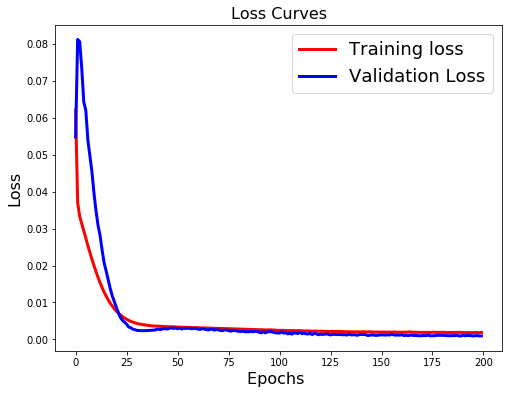

In [29]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [30]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100N, train_y_100N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100N, test_y_100N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)


In [31]:
# Vorhersagen generieren
trainPredict_100N = model.predict(trainX_100N)
testPredict_100N = model.predict(testX_100N)

In [32]:
# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(testPredict_100N)
trainPredict_100=scaler.inverse_transform(trainPredict_100N)

# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

5507400.373963891 10971776.126821559


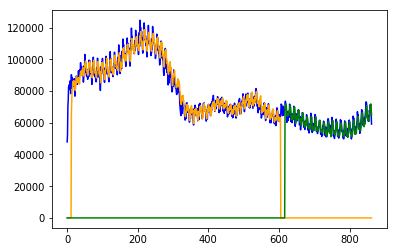

In [33]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+(2*look_back+look_forward-1):len(ZR_100)-(look_back+look_forward-1)+look_back] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [34]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [35]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(5, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_46N, train_y_46N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_46N, test_y_46N))

Train on 238 samples, validate on 138 samples
Epoch 1/200
 - 1s - loss: 0.0435 - val_loss: 0.0173
Epoch 2/200
 - 0s - loss: 0.0236 - val_loss: 0.0085
Epoch 3/200
 - 0s - loss: 0.0114 - val_loss: 0.0044
Epoch 4/200
 - 0s - loss: 0.0056 - val_loss: 0.0035
Epoch 5/200
 - 0s - loss: 0.0035 - val_loss: 0.0039
Epoch 6/200
 - 0s - loss: 0.0031 - val_loss: 0.0044
Epoch 7/200
 - 0s - loss: 0.0031 - val_loss: 0.0045
Epoch 8/200
 - 0s - loss: 0.0031 - val_loss: 0.0044
Epoch 9/200
 - 0s - loss: 0.0030 - val_loss: 0.0042
Epoch 10/200
 - 0s - loss: 0.0030 - val_loss: 0.0041
Epoch 11/200
 - 0s - loss: 0.0030 - val_loss: 0.0041
Epoch 12/200
 - 0s - loss: 0.0030 - val_loss: 0.0040
Epoch 13/200
 - 0s - loss: 0.0030 - val_loss: 0.0040
Epoch 14/200
 - 0s - loss: 0.0030 - val_loss: 0.0040
Epoch 15/200
 - 0s - loss: 0.0029 - val_loss: 0.0039
Epoch 16/200
 - 0s - loss: 0.0029 - val_loss: 0.0039
Epoch 17/200
 - 0s - loss: 0.0029 - val_loss: 0.0038
Epoch 18/200
 - 0s - loss: 0.0029 - val_loss: 0.0038
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0016 - val_loss: 0.0017
Epoch 155/200
 - 0s - loss: 0.0016 - val_loss: 0.0018
Epoch 156/200
 - 0s - loss: 0.0016 - val_loss: 0.0017
Epoch 157/200
 - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 158/200
 - 0s - loss: 0.0016 - val_loss: 0.0018
Epoch 159/200
 - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 160/200
 - 0s - loss: 0.0016 - val_loss: 0.0017
Epoch 161/200
 - 0s - loss: 0.0016 - val_loss: 0.0017
Epoch 162/200
 - 0s - loss: 0.0016 - val_loss: 0.0017
Epoch 163/200
 - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 164/200
 - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 165/200
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 166/200
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 167/200
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 168/200
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 169/200
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 170/200
 - 0s - loss: 0.0015 - val_loss: 0.0016
Epoch 171/200
 - 0s - loss: 0.0015 - val_loss: 0.0015
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

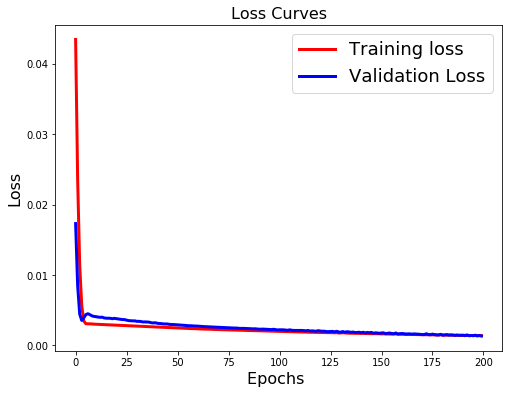

In [36]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [37]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_46N, train_y_46N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_46N, test_y_46N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)


In [38]:
# Vorhersagen generieren
trainPredict_46N = model.predict(trainX_46N)
testPredict_46N = model.predict(testX_46N)

In [39]:
# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(testPredict_46N)
trainPredict_46=scaler.inverse_transform(trainPredict_46N)



# Evaluation
test_MSE=mean_squared_error(test_y_46,testPredict_46)
train_MSE=mean_squared_error(train_y_46,trainPredict_46)

print(test_MSE,train_MSE)

7831239.348279981 8049712.472522383


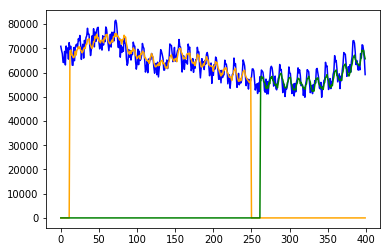

In [40]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_46)+(look_back+look_forward-1)] = trainPredict_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+(2*look_back+look_forward-1):len(ZR_46)-(look_back+look_forward-1)+look_back] = testPredict_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [89]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [90]:
# Modell zusammenbauen
# Dateninput: 12 %
model = Sequential()
model.add(Dense(5, input_dim=look_back, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_12N, train_y_12N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_12N, test_y_12N))

Train on 38 samples, validate on 38 samples
Epoch 1/200
 - 1s - loss: 0.0248 - val_loss: 0.0430
Epoch 2/200
 - 0s - loss: 0.0221 - val_loss: 0.0387
Epoch 3/200
 - 0s - loss: 0.0194 - val_loss: 0.0347
Epoch 4/200
 - 0s - loss: 0.0171 - val_loss: 0.0310
Epoch 5/200
 - 0s - loss: 0.0149 - val_loss: 0.0275
Epoch 6/200
 - 0s - loss: 0.0129 - val_loss: 0.0244
Epoch 7/200
 - 0s - loss: 0.0112 - val_loss: 0.0216
Epoch 8/200
 - 0s - loss: 0.0096 - val_loss: 0.0190
Epoch 9/200
 - 0s - loss: 0.0083 - val_loss: 0.0167
Epoch 10/200
 - 0s - loss: 0.0071 - val_loss: 0.0147
Epoch 11/200
 - 0s - loss: 0.0061 - val_loss: 0.0129
Epoch 12/200
 - 0s - loss: 0.0054 - val_loss: 0.0114
Epoch 13/200
 - 0s - loss: 0.0047 - val_loss: 0.0101
Epoch 14/200
 - 0s - loss: 0.0042 - val_loss: 0.0090
Epoch 15/200
 - 0s - loss: 0.0038 - val_loss: 0.0081
Epoch 16/200
 - 0s - loss: 0.0035 - val_loss: 0.0073
Epoch 17/200
 - 0s - loss: 0.0033 - val_loss: 0.0067
Epoch 18/200
 - 0s - loss: 0.0032 - val_loss: 0.0062
Epoch 19/20

Epoch 154/200
 - 0s - loss: 0.0019 - val_loss: 0.0049
Epoch 155/200
 - 0s - loss: 0.0019 - val_loss: 0.0049
Epoch 156/200
 - 0s - loss: 0.0019 - val_loss: 0.0049
Epoch 157/200
 - 0s - loss: 0.0019 - val_loss: 0.0049
Epoch 158/200
 - 0s - loss: 0.0019 - val_loss: 0.0048
Epoch 159/200
 - 0s - loss: 0.0019 - val_loss: 0.0047
Epoch 160/200
 - 0s - loss: 0.0018 - val_loss: 0.0046
Epoch 161/200
 - 0s - loss: 0.0018 - val_loss: 0.0046
Epoch 162/200
 - 0s - loss: 0.0018 - val_loss: 0.0045
Epoch 163/200
 - 0s - loss: 0.0018 - val_loss: 0.0045
Epoch 164/200
 - 0s - loss: 0.0018 - val_loss: 0.0044
Epoch 165/200
 - 0s - loss: 0.0018 - val_loss: 0.0044
Epoch 166/200
 - 0s - loss: 0.0018 - val_loss: 0.0044
Epoch 167/200
 - 0s - loss: 0.0018 - val_loss: 0.0043
Epoch 168/200
 - 0s - loss: 0.0018 - val_loss: 0.0043
Epoch 169/200
 - 0s - loss: 0.0018 - val_loss: 0.0043
Epoch 170/200
 - 0s - loss: 0.0018 - val_loss: 0.0044
Epoch 171/200
 - 0s - loss: 0.0018 - val_loss: 0.0044
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

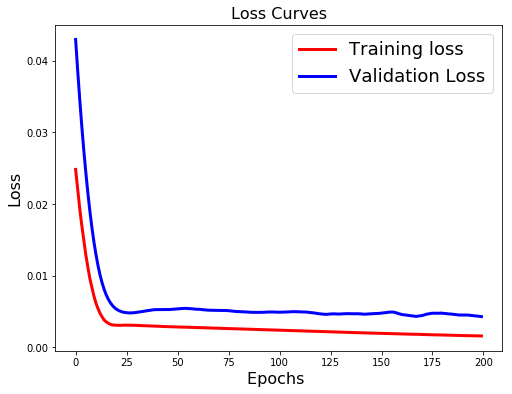

In [91]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [92]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_12N, train_y_12N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_12N, test_y_12N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.07 RMSE)


In [93]:
# Vorhersagen generieren
trainPredict_12N = model.predict(trainX_12N)
testPredict_12N = model.predict(testX_12N)

In [94]:
# Prediction Denormalizing
testPredict_12=scaler.inverse_transform(testPredict_12N)
trainPredict_12=scaler.inverse_transform(trainPredict_12N)

# Evaluation
test_MSE=mean_squared_error(test_y_12,testPredict_12)
train_MSE=mean_squared_error(train_y_12,trainPredict_12)

print(test_MSE,train_MSE)

25063085.239663776 9125726.366049515


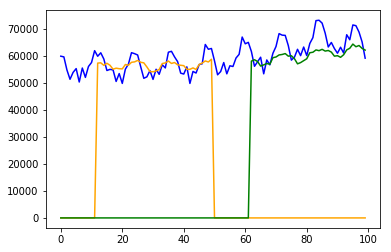

In [95]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_12)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_12))
trainPredictPlot[:]=[0]*len(ZR_12)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_12),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_12)+(look_back+look_forward-1)] = trainPredict_12

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_12)
testPredictPlot=testPredictPlot.reshape(len(ZR_12))
testPredictPlot[:]=[0]*len(ZR_12)
testPredictPlot = testPredictPlot.reshape(len(ZR_12),1)
testPredictPlot[len(trainPredict_12)+(2*look_back+look_forward-1):len(ZR_12)-(look_back+look_forward-1)+look_back] = testPredict_12
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_12, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()